<a href="https://colab.research.google.com/github/noelfischer/mldm_praktika/blob/main/L05_Supervised_Learning_LAB_ASSIGNMENT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [4]:
RANDOM_SEED = 0x0

# TASK 1: Metrics (5 Points)
In this task you will compute some standard quality measures like Precision, Recall and F-Score for an artificial dataset.

First, we generate some artificial data for a binary classification task and take a look at it.

In [5]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X, y = make_blobs(n_samples=500, centers=2, random_state=RANDOM_SEED, cluster_std=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

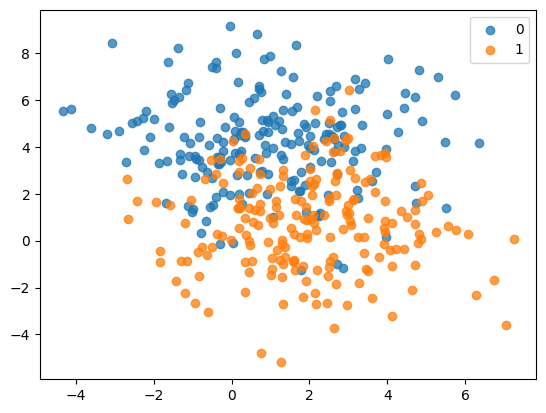

In [6]:
for target_class in np.unique(y):
  plt.scatter(X_train[y_train==target_class, 0], X_train[y_train==target_class, 1], alpha=0.75, label=target_class)
plt.legend()
plt.show()

As we can see, the classes are not easily distinguishable, and there is no linear separator between the two classes. Nevertheless, let's apply a Logistic Regression Model and predict `y` values.

In [7]:
log_reg = LogisticRegression(random_state=RANDOM_SEED).fit(X_train, y_train)
y_test_pred = log_reg.predict(X_test)

### Create and visualise the confusion matrix that describes the results:

1. Create confusion matrix. Use can use `sklearn.metrics.confusion_matrix` functions.
2. Display the confusion matrix of the Logistic Regression Model with `seaborn.heatmap`. Include the numbers of samples in each cell of the heatmap.

<Axes: >

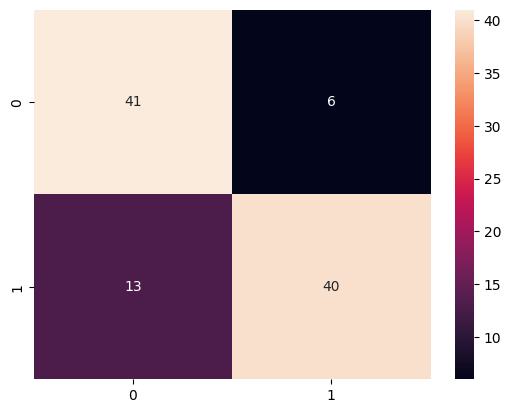

In [8]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
# TODO: finish me
confusion_matrix_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(confusion_matrix_test, annot=True)

### Task 1A. Create functions that calculate Precision, Recall and F1-Score (2 points)
1. Implement your own functions for calculating Precision, Recall and F1-Score from the confusion matrix. Don't use any of the existing libraries for this.
2. Apply them on the example above for the class `0`.

In [9]:
def precision(class_of_interest, confusion_matrix_test):
  TP = confusion_matrix_test[class_of_interest, class_of_interest]
  FP = confusion_matrix_test[:, class_of_interest].sum() - TP
  return TP / (TP + FP) if (TP + FP) > 0 else 0

def recall(class_of_interest, confusion_matrix_test):
  TP = confusion_matrix_test[class_of_interest, class_of_interest]
  FN = confusion_matrix_test[class_of_interest, :].sum() - TP
  return TP / (TP + FN) if (TP + FN) > 0 else 0

def f1_score(precision_value, recall_value):
  return 2 * (precision_value * recall_value) / (precision_value + recall_value) if (precision_value + recall_value) > 0 else 0

In [10]:
precision_value = precision(0, confusion_matrix_test)
recall_value = recall(0, confusion_matrix_test)
f1_score_test = f1_score(precision_value, recall_value)

print(f"Precision: {precision_value}")
print(f"Recall: {recall_value}")
print(f"F1-Score: {f1_score_test}")

Precision: 0.7592592592592593
Recall: 0.8723404255319149
F1-Score: 0.8118811881188118


## 📢 **HAND-IN** 📢:

What is the F1-Score that you computed?

### Check your results
Use the function `classification_report` of `sklearn.metrics` to compare their results to your own implementation

In [11]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_test_pred, digits=3))

              precision    recall  f1-score   support

           0      0.759     0.872     0.812        47
           1      0.870     0.755     0.808        53

    accuracy                          0.810       100
   macro avg      0.814     0.814     0.810       100
weighted avg      0.818     0.810     0.810       100



### Task 1B. Multi-Class Dataset and One-v-Rest Classification (3 points)
Now let's do a similar analysis for a multi-class classification task with 4 classes. First, let's make the dataset:

In [12]:
X, y = make_blobs(n_samples=500, centers=4, random_state=RANDOM_SEED, cluster_std=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

Instead of just using the built-in multi-classification technique of sklearn.linear_model.LogisticRegression, you should build your own multi-classifier using the one-v-rest technique explained in class. In particular, train 4 different binary classifiers, one for each class. The job of classifier i is to distinguish between examples that belong to that class i from examples that belong to any other class j != i. After training the 4 classifiers, you can classify each test example based on the highest probability output by any of the 4 classfiiers (use predict_proba and select outputs ``[:,1]``, i.e., the probability corresponding to its "positive" class for each example).

In [13]:
from matplotlib.colors import ListedColormap

# Visualization of decision boundaries
def plot_decision_boundaries(X, y, classifiers, n_classes, title="Decision Boundaries"):
    # Define colors for the plot
    cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF', '#AAFFAA', '#FFD700'])
    cmap_bold = ['#FF0000', '#0000FF', '#00FF00', '#FFA500']

    # Create a mesh grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    # Predict class probabilities for each point in the mesh grid
    Z = np.zeros((xx.ravel().shape[0], n_classes))
    for i, clf in classifiers.items():
        Z[:, i] = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

    # Select the class with the highest probability for each point
    Z_final = np.argmax(Z, axis=1).reshape(xx.shape)

    # Plot the decision boundary by assigning colors to each region
    plt.figure(figsize=(10, 7))
    plt.contourf(xx, yy, Z_final, cmap=cmap_light, alpha=0.6)

    # Overlay the training points
    for i, color in zip(range(n_classes), cmap_bold):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, label=f"Class {i}",
                    edgecolor='k', s=60, alpha=0.8)

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(title)
    plt.legend(loc="best")
    plt.show()

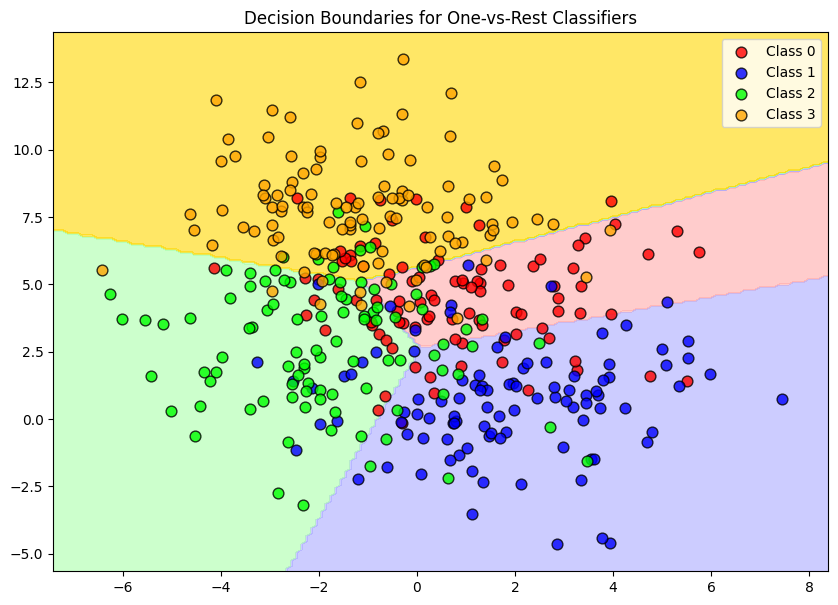

              precision    recall  f1-score   support

           0      0.765     0.448     0.565        29
           1      0.667     0.880     0.759        25
           2      0.700     0.724     0.712        29
           3      0.800     0.941     0.865        17

    accuracy                          0.720       100
   macro avg      0.733     0.748     0.725       100
weighted avg      0.727     0.720     0.707       100



In [14]:
# TODO: implement one-v-rest multi-class classifier
classifiers = {}
n_classes = len(np.unique(y))

for i in range(n_classes):
    y_train_binary = (y_train == i).astype(int)
    clf = LogisticRegression(random_state=RANDOM_SEED)
    clf.fit(X_train, y_train_binary)
    classifiers[i] = clf

y_test_pred_proba = np.zeros((X_test.shape[0], n_classes))
for i, clf in classifiers.items():
    y_test_pred_proba[:, i] = clf.predict_proba(X_test)[:, 1]

yhat = np.argmax(y_test_pred_proba, axis=1)

print(classification_report(y_test, yhat, digits=3))

# plot_decision_boundaries(X_train, y_train, classifiers, n_classes, title="Decision Boundaries for One-vs-Rest Classifiers")

## 📢 **HAND-IN** 📢

1. Your code for one-v-rest approach
2. The average F1 score over all 4 classes

Again, you can compare the accuracy of the one-v-rest approach you implemented to the built-in multi-class classification approach of sklearn.linear_model.LogisticRegression. Which has the higher average (over all 4 classes) F1 (no hand-in)?

In [15]:
log_reg.fit(X_train, y_train)
yhat = log_reg.predict(X_test)
print(classification_report(y_test, yhat, digits=3))

              precision    recall  f1-score   support

           0      0.636     0.483     0.549        29
           1      0.643     0.720     0.679        25
           2      0.700     0.724     0.712        29
           3      0.800     0.941     0.865        17

    accuracy                          0.690       100
   macro avg      0.695     0.717     0.701       100
weighted avg      0.684     0.690     0.682       100



# TASK 2. Cross Validation (5 points)

Using the same toy dataset as in Task 1, use cross-validation instead of a fixed train-test data split. In particular, implement a function ``kFoldCV`` that takes as parameters the number of examples n in a dataset, and the number of folds  k. The function should return two arrays of indices -- idxsTr and idxsTe -- which specify the indices of the training and testing examples (respectively) in the k different folds. In particular, idxsTe is an array with k elements, whereby idxsTe[0] should contain the first n/k indices; idxsTe[1] should contain the next n/k examples; and so on. Correspondingly, idxsTr is an array with k elements, whereby idxsTr[i] contains all the indices [0,1,2,...,n-1] *except* those in idxsTe[i].
If n is not exactly divisible by k, then only the *last* testing fold (i.e., idxsTe[k-1]) should receive fewer examples.

Example 1: ``kFoldCV(n=6, k=3)`` should return:
```
idxsTe = [ [ 0, 1 ], [ 2, 3 ], [ 4, 5 ] ]
idxsTr = [ [ 2, 3, 4, 5 ], [ 0, 1, 4, 5 ], [ 0, 1, 2, 3 ] ]
```

Example 2: ``kFoldCV(n=5, k=3)`` should return:
```
idxsTe = [ [ 0, 1 ], [ 2, 3 ], [ 4 ] ]
idxsTr = [ [ 2, 3, 4 ], [ 0, 1, 4 ], [ 0, 1, 2, 3 ] ]
```

In [20]:
def kFoldCV (n: int, k: int):
  idxsTr = []
  idxsTe = []
  # TODO: implement me
  fold_size = n // k
  remainder = n % k
  indices = np.arange(n)

  fold_indices = []
  start_idx = 0
  for i in range(k):
      end_idx = start_idx + fold_size + (1 if i < remainder else 0)
      fold_indices.append(indices[start_idx:end_idx])
      start_idx = end_idx

  for i in range(k):
      test_indices = fold_indices[i]
      train_indices = np.hstack([fold_indices[j] for j in range(k) if j != i])
      idxsTe.append(test_indices)
      idxsTr.append(train_indices)

  return idxsTr, idxsTe

In [21]:
kFoldCV(n=5, k=3)

([array([2, 3, 4]), array([0, 1, 4]), array([0, 1, 2, 3])],
 [array([0, 1]), array([2, 3]), array([4])])

Now, using the kFoldCV method you just implemented, compute the cross-validation accuracy on the synthetic dataset from Task 1 using k=5 folds: For each fold, train on the training portion and then test on the testing portion. Report the mean, as well as the standard deviation, of accuracy (i.e., proportion of examples that are correctly classified) over all 5 folds.

In [22]:
from sklearn.metrics import accuracy_score

def computeCVAccuracy (k):
  accuracies = []

  idxsTr, idxsTe = kFoldCV(len(y), k)

  for i in range(k):
      X_train, X_test = X[idxsTr[i]], X[idxsTe[i]]
      y_train, y_test = y[idxsTr[i]], y[idxsTe[i]]

      model = LogisticRegression()
      model.fit(X_train, y_train)

      y_pred = model.predict(X_test)
      acc = accuracy_score(y_test, y_pred)
      accuracies.append(acc)

  mean_accuracy = np.mean(accuracies)
  std_accuracy = np.std(accuracies)

  return mean_accuracy, std_accuracy

Now, vary the number of folds k over the set [ 5, 10, 15, ..., 30 ], and recompute the mean cross-validation accuracy and its standard deviation each time (for each k). What trend do you observe? Why do you think it happens? Based on your result, name one advantage and one disadvantage of performing k-fold cross-validation with a large k value.

In [23]:
# TODO: implement me
ks = range(5, 31, 5)
results = []

for k in ks:
    mean_acc, std_acc = computeCVAccuracy(k)
    results.append((k, mean_acc, std_acc))
    print(f"Folds: {k}, Mean Accuracy: {mean_acc:.3f}, Std Accuracy: {std_acc:.3f}")

Folds: 5, Mean Accuracy: 0.696, Std Accuracy: 0.043
Folds: 10, Mean Accuracy: 0.702, Std Accuracy: 0.052
Folds: 15, Mean Accuracy: 0.700, Std Accuracy: 0.081
Folds: 20, Mean Accuracy: 0.694, Std Accuracy: 0.085
Folds: 25, Mean Accuracy: 0.694, Std Accuracy: 0.111
Folds: 30, Mean Accuracy: 0.695, Std Accuracy: 0.128


## 📢 **HAND-IN** 📢: Answer following question in Moodle:

On Moodle, submit the accuracy scores and their standard deviations for the increasing values of k, and explain the trend.

# TASK 3. Optimal Threshold Selection (2 points)
Probabilistic classifiers such as logistic regression output a real number between 0 and 1, which expresses how certain/confident the model is that the input example belongs to the positive class. However, to make a final (binary) classification decision, we have to apply some threshold to this number. Oftentimes, 0.5 is taken as the threshold, which is intuitive since it is halfway between 0 and 1. However, this value is actually arbitrary.

A more sensible way of picking the threshold is based on the **cost** involved in making different kinds of mistakes. In binary decision problems, there can be false positives (mistakenly classifying a negative example as a positive) and false negatives (mistakenly classifying a positive example as a negative). These two kinds of mistakes may have different real-world costs associated with them. For instance, in a machine learning setting in which a credit card company wants to predict whether a customer will enter "default"/bankruptcy and wants to automatically "warn" the customer not to forget their payment, the costs could be:
- False positive: Telling a customer you are concerned they might not pay their bill, even though they always do, can be insulting. It could cause them to move their business elsewhere.
- False negative: Not telling a customer you are concerned even though they will forget to pay a bill can result in lost revenue for the company.

Based on the relative magnitude of these costs, it may be more important to keep the number of false positives low at the expense of accruing more false negatives; or the reverse might be true.

With this in mind, this task will explore how to calculate an optimal threshold automatically, given a pre-defined cost configuration of false positives and false negatives.

### Dataset:
In this task we will work with the **Default of Credit Card Clients Dataset**. This dataset contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from April 2005 to September 2005. More info about the dataset can be found [here](https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset).

The target variable is:

- `default.payment.next.month`: Default payment (1=yes, 0=no)

Default payment means a missed payment. So, the target variable shows whether a person will miss his or her Credit Card Payment (=1) or will pay it back (=0).

The predictor features are:
*   ID: ID of each client
*   LIMIT_BAL: Amount of given credit in NT dollars (includes individual and family/supplementary credit
*   SEX:0, SEX:1: Binary variables for gender (0=male, 1=female)
*   EDUCATION:0-EDUCATION:5: Binary variables for education (0=graduate school, 1=university, 2=high school, 3=others, 4=unknown, 5=unknown)
*   MARRIAGE:0-MARRIAGE:2: Binary variables for Marital status (0=married, 1=single, 2=others)
*   AGE: Age in years
*   PAY_0: Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, … 8=payment delay for eight months, 9=payment delay for nine months and above)
*   PAY_2: Repayment status in August, 2005 (scale same as above)
*   PAY_3: Repayment status in July, 2005 (scale same as above)
*   PAY_4: Repayment status in June, 2005 (scale same as above)
*   PAY_5: Repayment status in May, 2005 (scale same as above)
*   PAY_6: Repayment status in April, 2005 (scale same as above)
*   BILL_AMT1: Amount of bill statement in September, 2005 (NT dollar)
*   BILL_AMT2: Amount of bill statement in August, 2005 (NT dollar)
*   BILL_AMT3: Amount of bill statement in July, 2005 (NT dollar)
*   BILL_AMT4: Amount of bill statement in June, 2005 (NT dollar)
*   BILL_AMT5: Amount of bill statement in May, 2005 (NT dollar)
*   BILL_AMT6: Amount of bill statement in April, 2005 (NT dollar)
*   PAY_AMT1: Amount of previous payment in September, 2005 (NT dollar)
*   PAY_AMT2: Amount of previous payment in August, 2005 (NT dollar)
*   PAY_AMT3: Amount of previous payment in July, 2005 (NT dollar)
*   PAY_AMT4: Amount of previous payment in June, 2005 (NT dollar)
*   PAY_AMT5: Amount of previous payment in May, 2005 (NT dollar)
*   PAY_AMT6: Amount of previous payment in April, 2005 (NT dollar)

In [24]:
# install datasets
!pip install datasets

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.4 MB/s eta 0:00:00


First, we load and inspect the data.

In [25]:
from datasets import load_dataset

dataset = load_dataset("imodels/credit-card")
df_train = pd.DataFrame(dataset['train'])
X_train = df_train.drop(columns=['default.payment.next.month'])
y_train = df_train['default.payment.next.month'].values
print(X_train.head())

df_test = pd.DataFrame(dataset['test'])
X_test = df_test.drop(columns=['default.payment.next.month'])
y_test = df_test['default.payment.next.month'].values

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.32k [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/4.22M [00:00<?, ?B/s]

test.csv:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/24000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6000 [00:00<?, ? examples/s]

   limit_bal   age  pay_0  pay_2  pay_3  pay_4  pay_5  pay_6  bill_amt1  \
0    80000.0  24.0    0.0    0.0    0.0    0.0    0.0    0.0    75125.0   
1    30000.0  28.0    0.0    0.0    0.0    0.0    0.0    0.0    29242.0   
2   180000.0  44.0    0.0    0.0   -1.0   -1.0   -1.0   -1.0    20916.0   
3    60000.0  25.0    0.0    0.0    0.0    0.0    0.0    0.0    58839.0   
4   130000.0  25.0    0.0    0.0    0.0    0.0    0.0    0.0   111587.0   

   bill_amt2  ...  education:1  education:2  education:3  education:4  \
0    77353.0  ...          0.0          1.0          0.0          0.0   
1    29507.0  ...          0.0          1.0          0.0          0.0   
2        0.0  ...          0.0          0.0          0.0          0.0   
3    53235.0  ...          1.0          0.0          0.0          0.0   
4   112348.0  ...          0.0          1.0          0.0          0.0   

   education:5  education:6  marriage:0  marriage:1  marriage:2  marriage:3  
0          0.0          0.0     

###  Standardization of the data
We first apply "Standardization" to the data, i.e. we scale the data such that they look more or less like standard normally distributed. You can use the `StandardScaler` from the `sklearn` library, which subtracts the mean and divides by the standard deviation of each feature (as computed on the training set). This can sometimes improve prediction accuracy.

In [26]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Logistic Regression
We now apply Logistic regression to the data in order to predict `default.payment.next.month`.

In [27]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression()

### TASK: Threshold Optimization
Given a false positive (i.e., incorrectly predict that someone will default) cost of 100 NT, and a false negative (i.e., incorrectly predict that someone will not default) cost of 1000 NT, and given a set of possible threshold values [ 0.1, 0.2, ..., 0.9 ], what is the best threshold?

In [28]:
from sklearn.metrics import confusion_matrix

# Function to find the best threshold based on costs
def findBestThreshold(fpCost, fnCost, thresholds, y_true, y_probs):
    best_threshold = 0
    best_cost = float('inf')

    for threshold in thresholds:
        y_pred = (y_probs >= threshold).astype(int)
        cm = confusion_matrix(y_true, y_pred)
        if cm.shape[0] < 2 or cm.shape[1] < 2:
            continue

        # Make sure that values are there
        tn = cm[0, 0] if cm.shape[0] > 0 and cm.shape[1] > 0 else 0
        fp = cm[0, 1] if cm.shape[0] > 0 and cm.shape[1] > 1 else 0
        fn = cm[1, 0] if cm.shape[0] > 1 and cm.shape[1] > 0 else 0
        tp = cm[1, 1] if cm.shape[0] > 1 and cm.shape[1] > 1 else 0

        total_cost = fp * fpCost + fn * fnCost

        if total_cost < best_cost:
            best_cost = total_cost
            best_threshold = threshold

    return best_threshold, best_cost

thresholds = np.arange(0.1, 1.0, 0.1)
fpCost = 100
fnCost = 1000
best_threshold, best_cost = findBestThreshold(fpCost, fnCost, thresholds, y_test, log_reg.predict_proba(X_test)[:, 1])
print(f"Best Threshold: {best_threshold}, Minimum Total Cost: {best_cost}")

fpCost = 500
fnCost = 500
best_threshold_balanced, best_cost_balanced = findBestThreshold(fpCost, fnCost, thresholds, y_test, log_reg.predict_proba(X_test)[:, 1])
print(f"Best Threshold Balanced: {best_threshold_balanced}, Minimum Total Cost Balanced: {best_cost_balanced}")


Best Threshold: 0.1, Minimum Total Cost: 494900
Best Threshold Balanced: 0.4, Minimum Total Cost Balanced: 552000


Suppose the costs of a false negative and a false positive are more similar, e.g., both are 500 NT. What is the best threshold then?

## 📢 **HAND-IN** 📢: Please hand in the following on Moodle:

1. Your implementation of findBestThreshold.
2. What is the best threshold for the costs of 100 NT dollars for false positives and 1000 NT dollars for false negatives?
3. What is the best threshold for the costs of 500 NT dollars for false positives and 500 NT dollars for false negatives?